In [147]:
using 
    Plots,
    StatPlots,
    RecipesBase,
    Colors, 
    Images,
    DataFrames,
    DataFramesMeta,
    Underscore,
    ConjugatePriors,
    Particles

flip(x::AbstractVector) = reshape(x, (1,:))

const It = Base.Iterators

using Revise
Revise.track("modeling.jl")
using DotLearning
include("experiments.jl")
include("plots.jl")

using JLD2
@load "data/dots2014.jld2"
@load "prior_empirical.jld2"
@load "results/run3-2018-07-18T12:40:07.059.jld2" results expts

2-element Array{Symbol,1}:
 :results
 :expts  

# Judgements are made in context

# Spatial memory task

* View location, then mask, then immediate recall.
* Dots occur in clusters of 3, 6, 9, or 12.

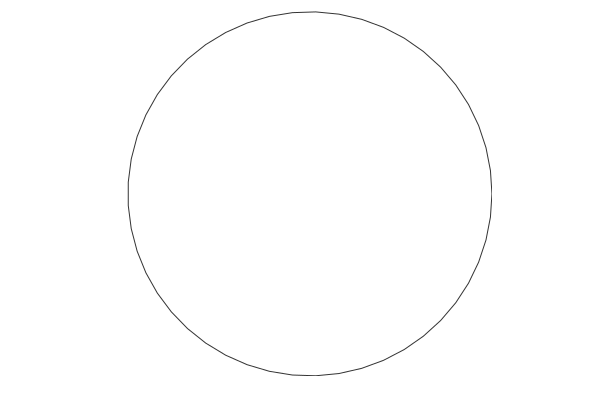

In [118]:
recall1 = @where(recall, :subjid1 .== first(:subjid1))
p = plot([], [], xlim=(-1,1), ylim=(-1,1), seriestype=:scatter, legend=false, 
         aspect_ratio=:equal, axis=false, grid=false, color="black", markersize=3,
         markeralpha=0.2
         )

plot!(cos.(linspace(0,2π)), sin.(linspace(0,2π)), color=Gray(0.2), seriestype=:path)

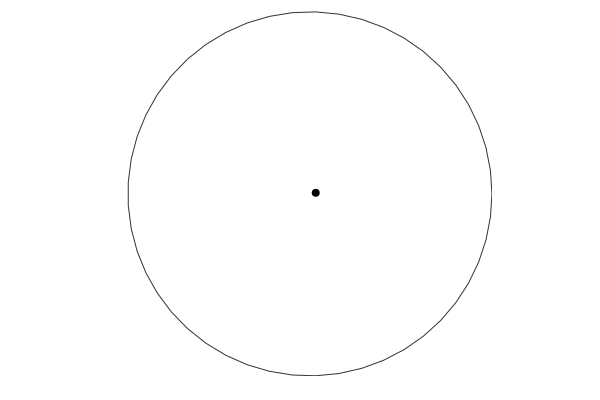

In [119]:
@df recall1 scatter!(:x[1:1], :y[1:1], color="black")

In [37]:
anim = @animate for (x,y) in @_ zip(recall1[:x], recall1[:y]) |> It.drop(_, 20) |> It.take(_, 20)
    push!(p, x,y)
end

gif(anim, "figures/task.gif", fps=10)

INFO: Saved animation to /home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/task.gif


Plots.AnimatedGif("/home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/task.gif")

# Recall is biased

* negative relationship between study and recall radius: more likely to under estimate a large radius
* "shrinkage"

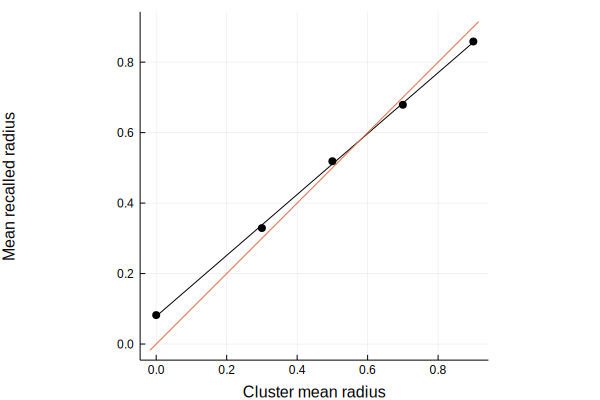

In [264]:
@_ recall |>
    @where(_, :block .> 1) |>
    @by(_, [:rad], rho_bias = mean(:new_rho_bias), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter(:rad, :rho_resp, color=:black, smooth=true, aspect_ratio=:equal, legend=false,
                   xlabel="Cluster mean radius", ylabel="Mean recalled radius"))

plot!(x->x, label="")

* Can see this more clearly plotting as the _bias_:
* negative slope means _shrinkage_

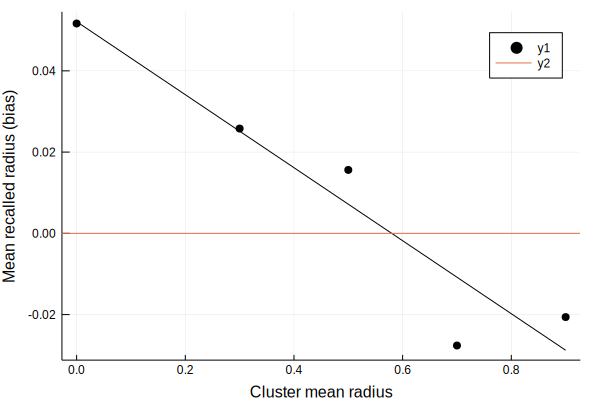

In [263]:
@_ recall |>
    @where(_, :block .> 1) |>
    @by(_, [:rad], rho_bias = mean(:new_rho_bias./2π), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter(:rad, :rho_bias, color=:black, smooth=true, xlabel="Cluster mean radius", ylabel="Mean recalled radius (bias)"))
plot!(0,0, seriestype=:hline)
hline!([0])

* how do we know that people are picking up on the clusters?
* That bias is stronger early in a cluster, suggesting people fall back on a global estimate in the absence of information about the specific cluster:

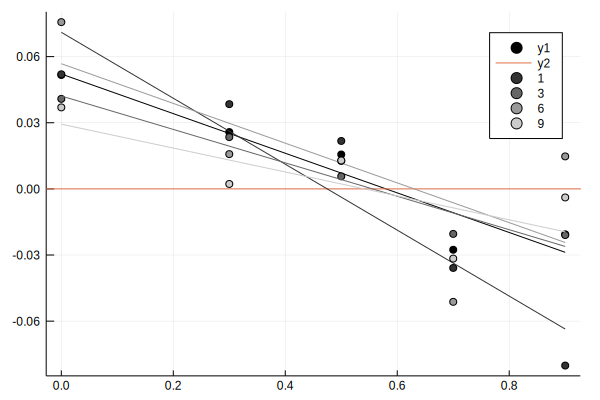

In [253]:
@_ recall |>
    @where(_, :block .> 1, [r ∈ [1,3,6,9] for r in :rep]) |>
    @by(_, [:rad, :rep], rho_bias = mean(:new_rho_bias./2π), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter!(:rad, :rho_bias, group=:rep, color=Gray.([.2 .4 .6 .8]), smooth=true, markeralpha=1))

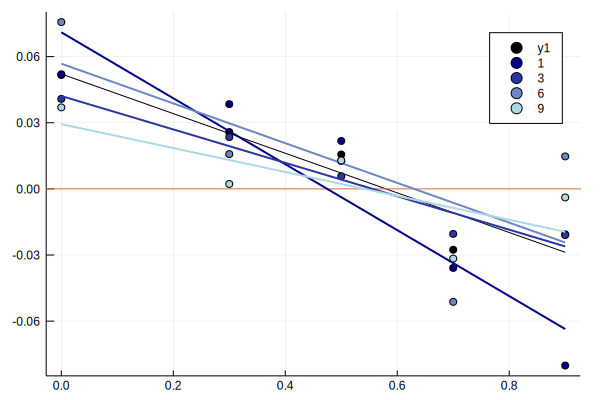

In [262]:
@_ recall |>
    @where(_, :block .> 1) |>
    @by(_, [:rad], rho_bias = mean(:new_rho_bias./2π), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter(:rad, :rho_bias, color=:black, smooth=true))
plot!(0,0, seriestype=:hline)
hline!([0], label="")

@_ recall |>
    @where(_, :block .> 1, [r ∈ [1,3,6,9] for r in :rep]) |>
    @by(_, [:rad, :rep], rho_bias = mean(:new_rho_bias./2π), rho_resp = mean(:rho_resp./2π)) |>
    @df(_, scatter!(:rad, :rho_bias, group=:rep, markerz=.-:rep, line=2, linez=.-:rep, color=:blues, smooth=true, markeralpha=1, colorbar=false))

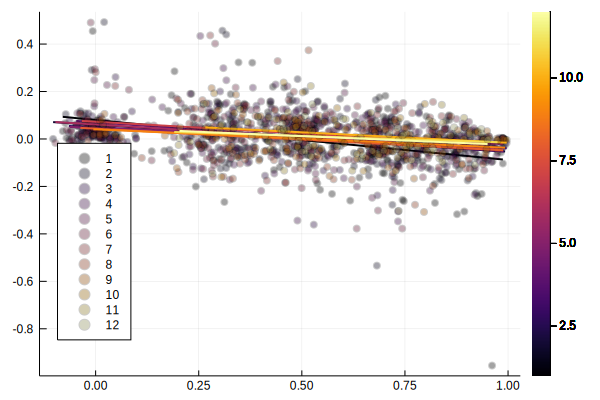

In [274]:
@_ recall |>
    @where(_, :block .> 1) |>
    @df(_, scatter(:rho ./ 2π, (abs.(:rho_resp).-abs.(:rho)) ./ 2π, group=:rep, smooth=true, markeralpha=0.2, 
        markerz = :rep, linez = :rep, linealpha=1, line=2, legend=:bottomleft))

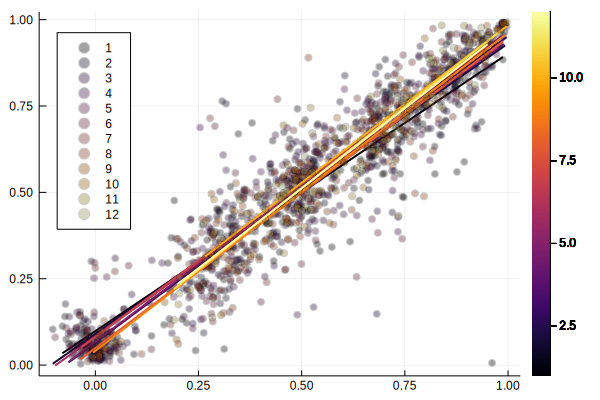

In [281]:
@_ recall |>
    @where(_, :block .> 1) |>
    @df(_, scatter(:rho ./ 2π, :rho_resp ./ 2π, group=:rep, smooth=true, markeralpha=0.2, 
        markerz = :rep, linez = :rep, linealpha=1, line=2, legend=:topleft))

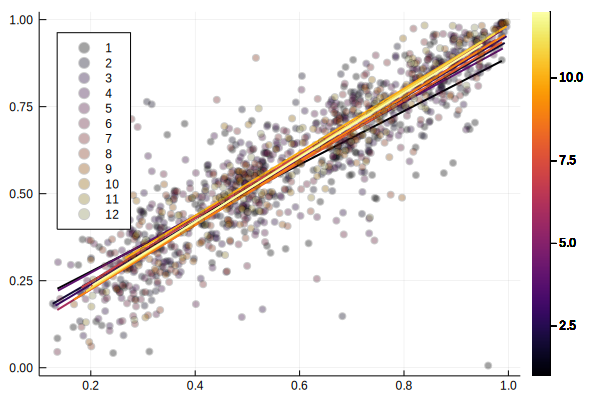

In [277]:
@_ recall |>
    @where(_, :block .> 1, :rad .> 0) |>
    @df(_, scatter(:rho ./ 2π, :rho_resp ./ 2π, group=:rep, smooth=true, markeralpha=0.2, 
        markerz = :rep, linez = :rep, linealpha=1, line=2, legend=:topleft))

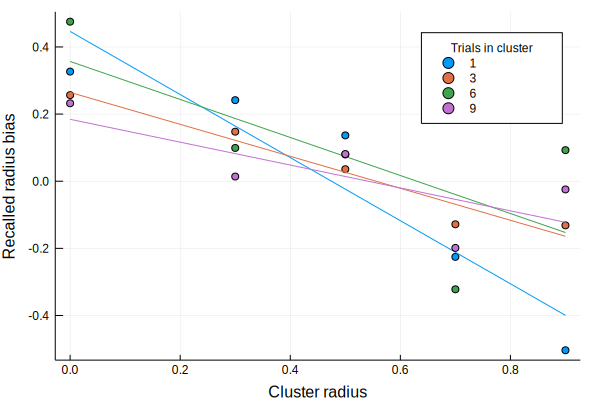

In [195]:
@_ recall |>
    @where(_, :block .> 1, [r ∈ [1, 3, 6, 9] for r in :rep]) |>
    @by(_, [:rep, :rad], rho_bias = mean(:new_rho_bias)) |>
    @df(_, scatter(:rad, :rho_bias, group=:rep, smooth=true, colorbar=false,
        legend_title="Trials in cluster",
                   xlabel="Cluster radius", ylabel="Recalled radius bias"))

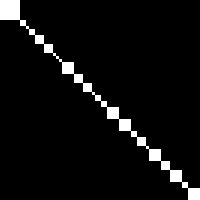

In [49]:
true_assignsim = Gray.(@with(recall1, :block .== :block'))

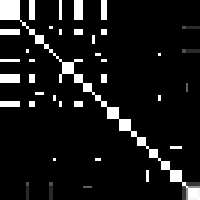

In [55]:
ps = ChenLiuParticles(1000, prior_optimized, StickyCRP(1.0, 0.9))
filter!(ps, extract_data(recall1, ps), false)
stickycrp = show_assignment_similarity(ps)

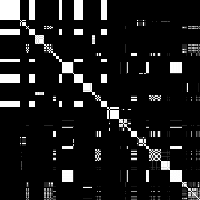

In [56]:
crp = @_ ChineseRestaurantProcess(1.0) |>
    ChenLiuParticles(100, prior_optimized, _) |>
    filter!(_, extract_data(recall1, _), false) |>
    show_assignment_similarity

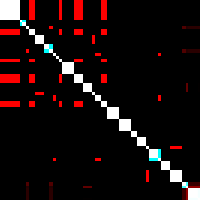

In [61]:
colorview(RGB, stickycrp, true_assignsim, true_assignsim)

In [189]:
e1, r1 = first(zip(expts, results))
mse(vcat(e1.data[1]...), vcat(first.(r1.result)...))

0.11896121254998285

In [180]:
e1.params

Dict{Symbol,Any} with 7 entries:
  :α     => 0.01
  :ρ     => 0.1
  :Sσ    => 0.0001
  :batch => :run2
  :n     => 100
  :iter  => 1
  :prior => ConjugatePriors.NormalInverseWishart{Float64}(…